从零实现一个具有张量的批量规范层

In [11]:
import torch
from torch import nn
from d2l import torch as d2l

def batch_norm(X, gamma, beta, moving_mean, moving_var, eps, momentum):
    """
    对当前小批量X，进行批量规范化

    Parameters
    -----------
        X : 小批量数据
        gramma : 拉伸参数
        beta : 偏移参数
        moving_mean : 移动平均的均值(历史值)
        moving_var : 移动平均的方差(历史值)
        eps : 方差中添加的噪声
        momentum : 指数加权移动平均(对移动平均历史值的保持率)
    
    Returns
    --------
        Y : 处理完毕的小批量数据
        moving_mean.data : 移动平均的均值(经本次小批量更新后)
        moving_var.data : 移动平均的方差(经本次小批量更新后)
    """
    # 通过is_grad_enabled方法来判断当前模式是训练模式还是预测模式
    if not torch.is_grad_enabled():
        # 如果是在预测模式下，直接使用传入的移动平均所得的均值和方差
        X_hat = (X-moving_mean) / torch.sqrt(moving_var+eps)
    else:
        assert len(X.shape) in (2, 4)
        if len(X.shape) == 2:
            # 使用全连接层的情况，计算特征维上的均值和方差
            mean = X.mean(dim=0)
            var = ((X - mean) ** 2).mean(dim=0)
        else:
            # 使用二维卷积层的情况，计算通道维上(axis=1)的均值和方差
            # 这里我们需要保持X的形状以便后面可以做广播运算
            mean = X.mean(dim=(0, 2, 3), keepdim=True)
            var = ((X-mean)**2).mean(dim=(0, 2, 3), keepdim=True)
        # 训练模式下, 用当前的均值和方差做标准化
        X_hat = (X-mean) / torch.sqrt(var+eps)
        # 更新移动平均的均值和方差
        moving_mean = momentum * moving_mean + (1.0 - momentum) * mean
        moving_var = momentum * moving_var + (1.0 - momentum) * var
    Y = gamma * X_hat + beta # 缩放和移位
    return Y, moving_mean.data, moving_var.data


In [12]:
class BatchNorm(nn.Module):
    """批量规范化层"""
    # num_features: 全连接层的输出数量或卷积层的输出通道数
    # num_dims: 2表示完全连接层，4表示卷积层
    def __init__(self, num_features, num_dims):
        super().__init__()
        if num_dims == 2:     # 完全连接层
            shape = (1, num_features)
        else:                 # 卷积层
            shape = (1, num_features, 1, 1)
        # 参与求梯度和迭代的拉伸参数和偏移参数，其分别初始化成1和0
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))
        # 非模型参数的变量初始化为0和1
        self.moving_mean = torch.zeros(shape)
        self.moving_var = torch.ones(shape)
    
    def forward(self, X):
        # 如果X不在内存上，将moving_mean和moving_var
        # 复制到X所在的显存上
        if self.moving_mean.device != X.device:
            self.moving_mean = self.moving_mean.to(X.device)
            self.moving_var = self.moving_var.to(X.device)
        # 保存更新过的moving_mean和moving_var
        Y, self.moving_mean, self.moving_var = batch_norm(X, self.gamma, self.beta, self.moving_mean,
                                                          self.moving_var, eps=1e-5, momentum=0.9)
        return Y

使用批量规范化层的LeNet

In [13]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), BatchNorm(6, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), BatchNorm(16, num_dims=4), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), BatchNorm(120, num_dims=2), nn.Sigmoid(),
    nn.Linear(120, 84), BatchNorm(84, num_dims=2), nn.Sigmoid(),
    nn.Linear(84, 10)
)

In [14]:
def try_xpu(i=0):
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.xpu.device_count() >= i+1:
        return torch.device(f'xpu:{i}')
    return torch.device('cpu')

loss 0.262, train acc 0.904, test acc 0.846
14246.2 examples/sec on xpu:0


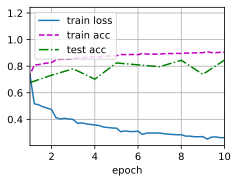

In [15]:
lr, num_epochs, batch_size = 1.0, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, try_xpu())

In [16]:
net[1].gamma.reshape((-1, )), net[1].beta.reshape((-1, ))

(tensor([2.4682, 4.6121, 2.5720, 2.3899, 2.6889, 2.8411], device='xpu:0',
        grad_fn=<ViewBackward0>),
 tensor([ 2.1721, -2.5556,  0.1284, -2.6027,  1.3887,  2.9713], device='xpu:0',
        grad_fn=<ViewBackward0>))

简明实现

In [17]:
net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5), nn.BatchNorm2d(6), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), nn.BatchNorm2d(16), nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2), nn.Flatten(),
    nn.Linear(16*4*4, 120), nn.BatchNorm1d(120), nn.Sigmoid(),
    nn.Linear(120, 84), nn.BatchNorm1d(84), nn.Sigmoid(),
    nn.Linear(84, 10)
)

loss 0.265, train acc 0.901, test acc 0.878
21133.8 examples/sec on xpu:0


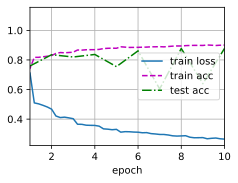

In [18]:
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, try_xpu())